In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pathlib import Path


DATA_PATH = Path.cwd().parent / "data"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    # torch.cuda.set_device(0)
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4060 Laptop GPU


Follow:

https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

https://pytorch.org/vision/main/generated/torchvision.datasets.DatasetFolder.html

In [3]:
mappings = json.load(open(DATA_PATH / "food101-mappings.json", "r"))
mappings = {v: k for k, v in mappings.items()}

Base image

In [4]:
BATCH_SIZE = 64

ttransform = v2.Compose([
    v2.ToImage(),  # Convert to PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.Resize(size=(400, 400), antialias=True),  # Or Resize(antialias=True)
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

vtransform = v2.Compose([
    v2.ToImage(),  # Convert to PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.Resize(size=(400, 400), antialias=True),  # Or Resize(antialias=True)
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_dataset = ImageFolder(root=DATA_PATH / 'nobg_input' / 'train', transform=ttransform)
val_dataset = ImageFolder(root=DATA_PATH / 'base_input' / 'valid', transform=vtransform)

In [6]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=True
)

valid_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9920372].


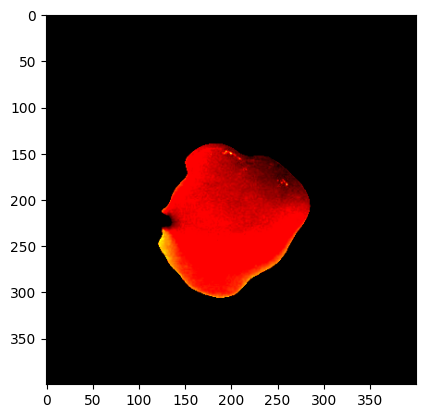

Label: 72 (panna_cotta)


In [7]:
for train_features, train_labels in iter(train_loader):
    img = train_features[63].squeeze()
    label = train_labels[63]
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print(f"Label: {label} ({mappings[int(train_dataset.classes[label].split('_')[-1])]})")
    break

In [16]:
# class CNNModel(nn.Module):
#     def __init__(self):
#         super(CNNModel, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 5)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(32, 64, 5)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv3 = nn.Conv2d(64, 128, 3)
#         self.conv4 = nn.Conv2d(128, 256, 5)
        
#         self.fc1 = nn.Linear(256, 101)
        
#         self.pool3 = nn.MaxPool2d(2, 2)
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         bs, _, _, _ = x.shape
#         x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
#         x = self.fc1(x)
#         return x
    
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        # self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # x = self.pool(self.relu(self.conv3(x)))
        # x = self.pool(self.relu(self.conv4(x)))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        
        return x

In [17]:
lr = 1e-3
epochs = 50
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
model = CNNModel().to(device)
print(model)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function
criterion = nn.CrossEntropyLoss()

Computation device: cuda

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
93,248 total parameters.
93,248 training parameters.


In [18]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc
# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)

# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/1184 [00:00<?, ?it/s]